In [1]:
#Нейро-нечеткие системы
#Лабораторная работа №5

#Задача: классификация текстов

In [2]:
#мешок слов

%matplotlib inline
import os
import umap
import seaborn as sns


from ipywidgets import Select, SelectMultiple, interactive,  Layout, Box, Label

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection
import sklearn.metrics as metrics
import matplotlib.patches as mpatches


import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
#import seaborn as sns
## for processing
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.feature_selection 
import nltk
import gensim
#перед использованием раскомментировать
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/msermakov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/msermakov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Sequential, Model, preprocessing as kprocessing
from keras.layers import Dense, Input, Activation, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras import models

In [4]:
biology = pd.read_excel("./data/articles/Biology.xlsx").dropna().head(100)
biology["class"] = "biology"
arts = pd.read_excel("./data/articles/Arts.xlsx").dropna().head(100)
arts["class"] = "arts"
chemistry = pd.read_excel("./data/articles/Chemistry.xlsx").dropna().head(100)
chemistry["class"] = "chemistry"
evolution = pd.read_excel("./data/articles/Evolution.xlsx").dropna().head(100)
evolution["class"] = "evolution"
math = pd.read_excel("./data/articles/Math.xlsx").dropna().head(100)
math["class"] = "math"
physics = pd.read_excel("./data/articles/Physics.xlsx").dropna().head(100)
physics["class"] = "physics"
policy_ethics = pd.read_excel("./data/articles/PolicyEthics.xlsx").dropna().head(100)
policy_ethics["class"] = "policy_ethics"
articles = pd.concat([biology, arts, chemistry, evolution, math, physics, policy_ethics])

In [5]:
articles.columns = ["text", "title", "class"]
articles = articles.dropna()
articles.head(10)

,text,title,class
0,This spring’s emergence of periodical cicadas ...,Brood X Cicadas Could Cause a Bird Baby Boom,biology
1,"In the 1980s, scientists discovered that oyste...",How a Carnivorous Mushroom Poisons Its Prey,biology
2,"In September 2017, when Hurricane Maria hit Pu...",What Monkeys Can Teach Humans about Resilience...,biology
3,A few plants in the cabbage and mustard family...,Killer Leaves Emerge from Plant-Butterfly Arms...,biology
4,The following essay is reprinted with permissi...,Chocolate’s Secret Ingredient Is Fermenting Mi...,biology
5,Dinosaur and fossil aficionados are intimately...,The Asteroid That Killed the Dinosaurs Created...,biology
6,The human body replaces its own cells regularl...,Our Bodies Replace Billions of Cells Every Day,biology
7,"Born in England in 1799, Anna Atkins was an am...",Female Botanist Published the First Ever Photo...,biology
8,Like an expert moviegoer who can instantly rec...,"Some Deep-Sea Bacteria Are So Strange, Our Imm...",biology
9,"In 1986, Yiu-Kwok Chan from Agriculture Canada...",Guardians of the Microbial Galaxy,biology


In [6]:
counter=CountVectorizer(
        token_pattern=r"[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+", 
        stop_words="english")

def get_most_freq_words(text, count=-1):
    try:
        res=counter.fit_transform([text])
        print(res)
    except ValueError:
        return None
    
    frq = sorted([(i, res[0,i]) for i in range(res[0].shape[1])], 
                 key = lambda x: x[1], reverse = True)[:count]
    vocab = {w:res[0,i] for w,i in counter.vocabulary_.items()}
    return [[w for w, n in counter.vocabulary_.items() if n==i][0] 
            for i, f in frq]

In [7]:
def normalize(text):
    words = get_most_freq_words(text)
    
    if not words:
        words = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
        sw = stopwords.words('english')
        lst_text = [word for word in words if word not in sw][:1001]

    # Стемминг
    ps = nltk.stem.porter.PorterStemmer()
    words = [ps.stem(word) for word in words]

    # Лемматизация
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    words = [lem.lemmatize(word) for word in words]

    return " ".join(words)

In [8]:
articles["cleaned"] = articles.text.apply(lambda text: normalize(text))
articles.head(10)

,text,title,class,cleaned
0,This spring’s emergence of periodical cicadas ...,Brood X Cicadas Could Cause a Bird Baby Boom,biology,cicada cicada speci popul say year year s bird...
1,"In the 1980s, scientists discovered that oyste...",How a Carnivorous Mushroom Poisons Its Prey,biology,s nematod nematod poison worm calcium fungi sc...
2,"In September 2017, when Hurricane Maria hit Pu...",What Monkeys Can Teach Humans about Resilience...,biology,social s say macaqu platt santiago island monk...
3,A few plants in the cabbage and mustard family...,Killer Leaves Emerge from Plant-Butterfly Arms...,biology,plant egg speci butterfli famili plant say but...
4,The following essay is reprinted with permissi...,Chocolate’s Secret Ingredient Is Fermenting Mi...,biology,chocol ferment bean cacao s bacteria flavor pr...
5,Dinosaur and fossil aficionados are intimately...,The Asteroid That Killed the Dinosaurs Created...,biology,s forest meteorit new speci say year amazon fo...
6,The human body replaces its own cells regularl...,Our Bodies Replace Billions of Cells Every Day,biology,cell bodi day equival human live mass percent ...
7,"Born in England in 1799, Anna Atkins was an am...",Female Botanist Published the First Ever Photo...,biology,alga atkin alga known seawe speci british meth...
8,Like an expert moviegoer who can instantly rec...,"Some Deep-Sea Bacteria Are So Strange, Our Imm...",biology,immun bacteria lp s deep-sea microb new recept...
9,"In 1986, Yiu-Kwok Chan from Agriculture Canada...",Guardians of the Microbial Galaxy,biology,microbi cultur collect collect world bacteri s...


In [9]:
corpus = articles["cleaned"]

# Сформируем список юниграмм
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

In [10]:
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, vector_size=50,   
            window=8, min_count=1, sg=1, epochs=10)

In [11]:
def text_to_vec(text):
    words = text.split(" ")
    vec = [nlp.wv.get_vector(word) for word in words if word in list(nlp.wv.index_to_key)]
    return np.asarray(vec).reshape(-1)

In [12]:
articles["vec"] = articles.cleaned.apply(lambda text: text_to_vec(text))
articles

,text,title,class,cleaned,vec
0,This spring’s emergence of periodical cicadas ...,Brood X Cicadas Could Cause a Bird Baby Boom,biology,cicada cicada speci popul say year year s bird...,"[-0.0955158, 0.0058344263, 0.05824702, -0.2898..."
1,"In the 1980s, scientists discovered that oyste...",How a Carnivorous Mushroom Poisons Its Prey,biology,s nematod nematod poison worm calcium fungi sc...,"[-0.37851056, -1.6177194, 0.13485555, 0.657888..."
2,"In September 2017, when Hurricane Maria hit Pu...",What Monkeys Can Teach Humans about Resilience...,biology,social s say macaqu platt santiago island monk...,"[-0.565434, -0.37565184, -0.32699335, -0.69469..."
3,A few plants in the cabbage and mustard family...,Killer Leaves Emerge from Plant-Butterfly Arms...,biology,plant egg speci butterfli famili plant say but...,"[-0.20477858, -0.62704396, 0.050016906, -0.480..."
4,The following essay is reprinted with permissi...,Chocolate’s Secret Ingredient Is Fermenting Mi...,biology,chocol ferment bean cacao s bacteria flavor pr...,"[-0.24356803, 0.27490088, 0.062146444, 0.02979..."
...,...,...,...,...,...
97,"Note: This post first appeared on November 21,...","Thanksgiving and the Myth of Native American ""...",policy_ethics,war nativ american s new peopl savag wampanoag...,"[-0.35744938, 0.6649792, 0.29443887, 0.0525428..."
98,"Since World War II, most countries around the ...",GDP Is the Wrong Tool for Measuring What Matters,policy_ethics,gdp s econom economi u health financi inequ we...,"[-0.0036418557, 0.030747574, 0.045131303, -0.0..."
99,Former Secretary of State John Kerry would bec...,Biden Names John Kerry Climate Envoy,policy_ethics,climat s kerri said biden chang domest presid ...,"[-0.74234414, 0.15228532, 0.496099, -0.2887067..."
100,"Personally, I practiced social distancing long...",The Scientific Benefits of Social Distancing,policy_ethics,research social phosphin public distanc life r...,"[0.16648796, -0.5830344, 0.84495705, 0.0719088..."


In [13]:
max_words = max(articles.vec.apply(lambda vec: len(vec)))
num_classes = 7

In [14]:
pad_data = kprocessing.sequence.pad_sequences(
    articles.vec, 
    maxlen=max(articles.vec.apply(lambda vec: len(vec))), 
    padding="post", 
    truncating="post",
    dtype="float32"
)

In [15]:
fit = umap.UMAP(
    n_neighbors=500,
    min_dist=0.01,
    n_components=2,
    metric="euclidean",
    random_state=42
)
    
umap_result = fit.fit_transform(pad_data)

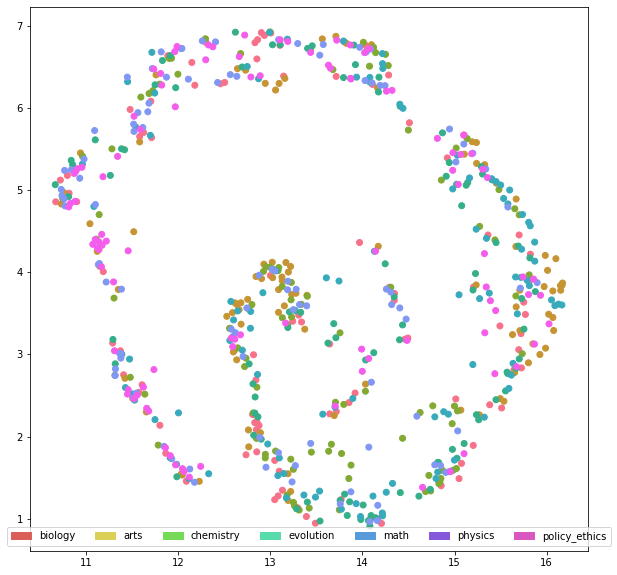

In [16]:
keys = list(articles["class"].value_counts().keys())
themes_dict = {keys[i]:i for i in range(len(keys))}
colors = [sns.color_palette("husl", len(themes_dict))[x] for x in articles["class"].map(themes_dict)]

fig = plt.figure(figsize=(10, 10))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=colors)

patches = [mpatches.Patch(color=sns.color_palette("hls", len(themes_dict))[i], label=keys[i]) for i in range(len(keys))]
plt.legend(handles=patches, ncol=10, loc="lower center")

In [34]:
x = articles["cleaned"].copy()
y = articles["class"].copy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
x_train

103    pheasant bird domest barton say wild bone chic...
17     woman dream w wilczek blackwel dream medic new...
62     carbon s fossil year radiocarbon research say ...
16     complex analysi function real number theorem p...
16     organ ocean s alga food impact photosynthesi s...
                             ...                        
67     theorem s episod favorit valu intermedi functi...
46     episod favorit theorem s group geometr duchin ...
54     s lift pressur wing air bernoulli airfoil expl...
51     episod theorem favorit s mirror symmetri podca...
26     conway s number kochen said t game professor d...
Name: cleaned, Length: 490, dtype: object

In [35]:
from keras.preprocessing import text, sequence
# #здесь тот же Bag of Words
# max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [36]:
tokenize.fit_on_texts(x_train) 
x_train = tokenize.texts_to_matrix(x_train, mode="tfidf")
x_test = tokenize.texts_to_matrix(x_test, mode="tfidf")

In [37]:
x_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [38]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [39]:
y_train

array([3, 0, 3, 4, 1, 2, 2, 4, 2, 3, 1, 2, 4, 4, 6, 3, 3, 5, 4, 2, 3, 0,
       3, 0, 5, 6, 5, 2, 2, 6, 3, 1, 6, 1, 1, 2, 6, 6, 0, 6, 6, 6, 1, 5,
       5, 4, 4, 0, 3, 0, 6, 4, 5, 0, 4, 6, 4, 6, 0, 4, 2, 3, 5, 2, 1, 5,
       5, 0, 6, 6, 5, 6, 2, 6, 4, 6, 6, 1, 0, 4, 1, 0, 0, 1, 3, 4, 6, 5,
       6, 0, 3, 0, 2, 0, 0, 1, 2, 0, 5, 2, 0, 4, 3, 5, 1, 0, 5, 6, 0, 2,
       5, 4, 5, 3, 2, 2, 4, 5, 4, 2, 2, 0, 0, 2, 0, 0, 4, 3, 1, 5, 6, 2,
       6, 5, 1, 3, 5, 0, 6, 4, 1, 5, 1, 3, 5, 3, 0, 3, 5, 3, 6, 0, 0, 1,
       4, 1, 1, 4, 3, 6, 4, 0, 3, 2, 6, 0, 0, 1, 4, 5, 4, 0, 2, 2, 6, 0,
       0, 2, 1, 0, 0, 4, 3, 4, 3, 3, 1, 3, 2, 6, 3, 2, 0, 3, 1, 1, 5, 1,
       1, 1, 3, 2, 6, 3, 6, 1, 0, 4, 6, 3, 6, 5, 3, 3, 2, 3, 2, 5, 4, 0,
       1, 6, 4, 1, 1, 4, 6, 2, 1, 6, 0, 2, 1, 2, 3, 5, 3, 5, 2, 1, 3, 3,
       5, 1, 0, 6, 2, 0, 5, 0, 2, 6, 3, 3, 2, 4, 2, 0, 5, 4, 3, 2, 0, 0,
       1, 2, 0, 2, 0, 6, 0, 3, 4, 1, 1, 1, 6, 0, 1, 2, 5, 2, 2, 3, 4, 6,
       3, 6, 5, 6, 1, 4, 4, 5, 2, 5, 3, 1, 5, 2, 5,

In [40]:
from keras.utils import np_utils
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [41]:
batch_size = 32
epochs = 20

model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               36506112  
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 3591      
_________________________________________________________________
activation_5 (Activation)    (None, 7)                 0         
Total params: 36,509,703
Trainable params: 36,509,703
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs, validation_split=0.1)

Epoch 1/20
14/14 [==============================] - 2s 116ms/step - loss: 1.4453 - accuracy: 0.5351 - val_loss: 1.2150 - val_accuracy: 0.5714
Epoch 2/20
14/14 [==============================] - 1s 106ms/step - loss: 0.2057 - accuracy: 0.9660 - val_loss: 1.3698 - val_accuracy: 0.6735
Epoch 3/20
14/14 [==============================] - 2s 111ms/step - loss: 0.1762 - accuracy: 0.9637 - val_loss: 1.7541 - val_accuracy: 0.4694
Epoch 4/20
14/14 [==============================] - 2s 108ms/step - loss: 0.1896 - accuracy: 0.9569 - val_loss: 1.4958 - val_accuracy: 0.6122
Epoch 5/20
14/14 [==============================] - 2s 116ms/step - loss: 0.1783 - accuracy: 0.9660 - val_loss: 1.5408 - val_accuracy: 0.5714
Epoch 6/20
14/14 [==============================] - 2s 112ms/step - loss: 0.0827 - accuracy: 0.9660 - val_loss: 1.6843 - val_accuracy: 0.6122
Epoch 7/20
14/14 [==============================] - 2s 109ms/step - loss: 0.1656 - accuracy: 0.9660 - val_loss: 1.6402 - val_accuracy: 0.6122
Epoch 

In [43]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 15ms/step - loss: 1.2673 - accuracy: 0.7143
Test accuracy: 0.7142857313156128
